In [1]:
import numpy as np
from numpy import linalg as LA
import math as m
import os
from matplotlib.image import imread   #behöbdes 
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing default values
import scipy.io as sio
from scipy.optimize import minimize
import timeit
import torch
import random

#For installation besides anaconda, vscode I needed to:
#In anaconda prompt
#conda activate base 
#conda install pytorch



## Problem 1:

Find the minimum value of $f(x)=(x-3)^2$ by writing your own steepest descent code. Assume the initial guess $x=1$. 

* Assume learning rate $\alpha=1.$, $0.75$, $0.5$, $0.25$. If convergence criteria is $ |df/dx|<1e-3 $, how many iterations are neeeded for the different $\alpha$? Does all values on $\alpha$ manage to converge?

* If you instead adopt the full Newton solver. How many iterations are needed until the same convergence criteria is fulfilled? 



Specific options for scipy optimizers (see https://docs.scipy.org/doc/scipy/tutorial/optimize.html) see

*Nelder-Mead simplex: https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html#optimize-minimize-neldermead

* L-BFGS: https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb







with alpha = 0.01, x = 2.999514517945703, nr of iterations: 412
with alpha = 0.25, x = 2.999755859375, nr of iterations: 13
with alpha = 0.5, x = 3.0, nr of iterations: 2
no convergence
with alpha = 1.0, x = 1.0, nr of iterations: 10000


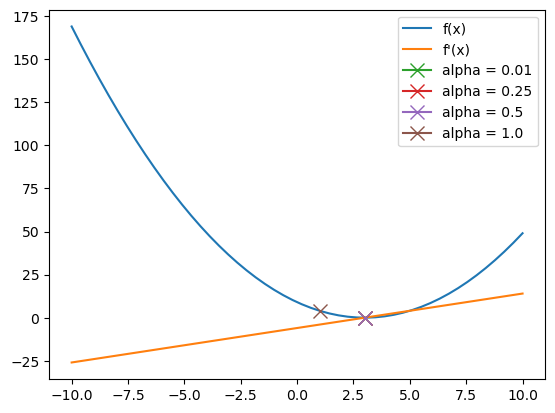

In [2]:
# Problem 1
import matplotlib.pyplot as plt


def f(x):
    return (x-3)**2


def dfdx(x_range):
    grads = []
    for vals in x_range:
        x = torch.tensor(vals, requires_grad=True)
        y = f(x)
        y.backward()
        grads.append(x.grad.item())

    return np.array(grads)


def steepest_descent(alf, x0, tol):
    xk = x0
    max_iter = 10000

    for iter in range(1,max_iter+1):
        g = 2*(xk-3)
        xk1 = xk - alf*g

        if abs(g) <= tol:
            return xk1, iter
        elif iter == max_iter:
            print('no convergence')
            return xk1, iter
        
        xk = xk1


x_vals = np.linspace(-10, 10)
alf_range = np.array([0.01, 0.25, 0.5, 1])

plt.figure(1)

plt.plot(x_vals, f(x_vals), label='f(x)')
plt.plot(x_vals, dfdx(x_vals), label = "f'(x)")

for alf in alf_range:
    xk, iter = steepest_descent(alf,1,1e-3)
    plt.plot(xk, f(xk), marker='x', markersize=10, label=f'alpha = {alf}')
    print(f'with alpha = {alf}, x = {xk}, nr of iterations: {iter}')

plt.legend()
plt.show()



## Problem 2: Rosenbrock function
Find the minimum to Rosenbrock's function $(a - x_1)^2 + b \,  (x_2 - x_1^2)^2$ with $a=1$ and $b=10$ by

a) using SciPy Nelder-Mead and BFGS. Starting guess $x_1=1.3$, $x_2=0.7$. Do both algorithms find the minimum? If not try with a better starting guess.

b) your own gradient descent solver. Investigate if you can find the solution by tuning the learning rate. How many iterations does it take to obtain convergence? Use tolerance $\sqrt{\nabla f \cdot \nabla f}<10^{-3}$

In [5]:
# Problem 2

# Enable external window plotting if running in Jupyter
try:
    get_ipython
    %matplotlib qt
except NameError:
    pass

def Rosenbrocks_fun(x):
    x1,x2 = x
    return(1 - x1)**2 + 10*(x2 - x1**2)**2

# Create a grid of x1, x2 values
x1 = np.linspace(-2, 2, 200)
x2 = np.linspace(-1, 3, 200)
X1, X2 = np.meshgrid(x1, x2)
x = np.array([X1,X2])

# Evaluate function on the grid
Z = Rosenbrocks_fun(x)


# Minimize function
x0 = np.array([1.3, 0.7])
res = minimize(Rosenbrocks_fun, x0, method='Nelder-Mead')
Xmin = res.x
fun_min = res.fun

# Make 3D surface plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

# Plot surface
surf = ax.plot_surface(X1, X2, Z, cmap="viridis", edgecolor="none", alpha=0.8)

# Plot minimum point
ax.scatter(Xmin[0], Xmin[1], fun_min, color='red', marker='x', s=100, label="minimum")

# Labels
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f(x1, x2)")
ax.set_title("Rosenbrock's Function")
ax.legend()

plt.show()

## Problem 3
For the experimental data set found in rubber_data.mat find the material parameter values of the Yeoh model that gives the best fit. The Yeoh model is defined as
$$ \sigma=c_1 \, (\lambda^2-1)+4 \, c_2 \lambda^2 (\lambda^2+2/\lambda-3)+6 \, c_3 \, \lambda \, (\lambda^2+2/\lambda-3)^2 $$
where $\lambda=\epsilon+1$ and the material parameters are $c_1$-$c_3$

a) Determine the parameter  values by adopting a cross-validation strategy. Withhold approx 10% of the data, validate against 10% of data, and train with 80% of the data. Use linear regression (pseudo-inverse).


In [1]:
#use code from Python help file
all_combinations = []
def generate_combinations(data_points, leave_out_count, start, comb=[]):
    if len(comb) == len(data_points) - leave_out_count:
        all_combinations.append(comb)
        return
    for i in range(start, len(data_points)):
        generate_combinations(data_points, leave_out_count,i + 1, comb + [data_points[i]])


def left_out_points_fcn(data_points,leave_out_count):
    generate_combinations(data_points, leave_out_count,0)
# Iterate through combinations and leave out  data points
    left_out_points=[]
    for combination in all_combinations:
        left_out_points.append(np.setdiff1d(data_points, combination))
    return np.array(left_out_points),np.array(all_combinations)

###### end from Python help file


b) Extend the Yeoh model by adding the terms $c_4 \, (\lambda-1)^6+c_5 \, (e^{-c_6 \, \lambda}-1)$. Use the cross-validation approach in a) again to find the parameter values. Use SciPy 'L-BFGS-B', with 'gtol=1.e-5 and  $x0 = [5.,-0.5,0.1,0.,0.,0.]$. 

c) Add L1 (LASSO) regularization on the added parameters ($c_4$-$c_6$) and solve b) again with different regularization parameters. Show how the results depend on the choice of regularization parameter. Try penalty 0.0001, 1, 10. se SciPy 'L-BFGS-B', with 'gtol=1.e-5 and  $x0 = [5.,-0.5,0.1,0.,0.,0.]$. For what of the values of the penalty parameter do we approach the parameter values found in a)?

## Problem 4

Minimize $f(x_1,x_2)=1/4 \, (f_1(x_1,x_2)+f_2(x_1,x_2)+f_3(x_1,x_2)+f_4(x_1,x_2))$ where
$$f_1=(x_1-1)^2+(x_2-1)^2$$
$$f_2=(x_1+1)^2+0.5 \, (x_2-1)^2$$
$$f_3=0.7 \, (x_1+1)^2+0.5 \, (x_2+1)^2$$
$$f_4=0.7 \, (x_1-1)^2+0.5 \, (x_2+1)^2$$
Use starting values $x_1=-1$ and $x_2=2$.

a) Implement the stochastic gradient descent to find the minimum. Assume a constant learning rate $\alpha=0.4$. Visualize the objective function value during the first 20 iterations.

b) Now adopt a decaying learning rate $\alpha_0=0.4$, ..., $\alpha_k=0.4/\sqrt{1+k}$, ... Visualize the objective function value during the first 20 iterations.

c) Try to find the solution by using optimization with Adagrad and LBFGS in Pytorch (see example in python_help.ipynb) 
